In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

# start_date = '2017-01-03'
# end_date = '2021-09-01'

start_date = '2015-01-01'
end_date = '2019-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-12-31 to 2018-12-31
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GNRC    1007 non-null   float64
 1   CPRT    1007 non-null   float64
 2   ODFL    1007 non-null   float64
 3   AMD     1007 non-null   float64
 4   PAYC    1007 non-null   float64
 5   CHTR    1007 non-null   float64
 6   MKC     1007 non-null   float64
 7   PG      1007 non-null   float64
 8   PGR     1007 non-null   float64
 9   NEM     1007 non-null   float64
 10  CCI     1007 non-null   float64
dtypes: float64(11)
memory usage: 94.4 KB


In [4]:
# close = panel_data['Close']
# adj_close = panel_data['Adj Close']

## Function that saves dataframe to CSV

In [5]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [6]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
    close = panel_data['Close']
    adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('close', close, ticker)
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [7]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [8]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [9]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [10]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

In [11]:
# port_list = ["AMD", "CPRT"]
# mult_df = merge_df_by_column_name('daily_return', '2018-01-02', 
#                                   '2021-09-10', *port_list)
# mult_df

## Get stock prices on date

In [12]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [13]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [14]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [15]:
#change to the list of stocks we using
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

#add in the weightage of stocks
port_shares = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

tot_port_df = get_port_daily_return('2015-01-01', '2019-01-01', port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314268,2.195364,1.685923,6.118073,46.790447,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078828,45.863213,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211587,7.246333,2.144215,1.766994,6.067287,45.287806,-0.012546
2015-01-07,2.2540,1.7960,2.407827,0.258,2.534,15.678999,3.297237,7.284344,2.188869,1.751302,6.194250,45.644828,0.007883
2015-01-08,2.2885,1.8145,2.471191,0.261,2.642,16.294000,3.351377,7.367645,2.232711,1.741713,6.291974,46.756611,0.024357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2.2765,4.4940,3.807592,1.665,11.154,27.351999,6.384308,8.045470,5.095202,3.125141,9.365529,82.764741,-0.030131
2018-12-26,2.4200,4.7430,3.968354,1.790,12.022,28.570001,6.588625,8.296889,5.296975,3.120623,9.704551,86.521019,0.045385
2018-12-27,2.4580,4.7820,4.060926,1.749,12.175,28.473001,6.669588,8.474636,5.374649,3.162195,9.727094,87.106089,0.006762


## Get old data for portfolio

In [16]:
tot_port_df = get_port_daily_return('2015-01-01', '2019-01-01', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314268,2.195364,1.685923,6.118073,46.790447,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078828,45.863213,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211587,7.246333,2.144215,1.766994,6.067287,45.287806,-0.012546
2015-01-07,2.2540,1.7960,2.407827,0.258,2.534,15.678999,3.297237,7.284344,2.188869,1.751302,6.194250,45.644828,0.007883
2015-01-08,2.2885,1.8145,2.471191,0.261,2.642,16.294000,3.351377,7.367645,2.232711,1.741713,6.291974,46.756611,0.024357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2.2765,4.4940,3.807592,1.665,11.154,27.351999,6.384308,8.045470,5.095202,3.125141,9.365529,82.764741,-0.030131
2018-12-26,2.4200,4.7430,3.968354,1.790,12.022,28.570001,6.588625,8.296889,5.296975,3.120623,9.704551,86.521019,0.045385
2018-12-27,2.4580,4.7820,4.060926,1.749,12.175,28.473001,6.669588,8.474636,5.374649,3.162195,9.727094,87.106089,0.006762


## Forecasting

In [17]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=1460, freq='D')

In [18]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [19]:
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2015-01-02,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314268,2.195364,1.685923,6.118073,46.790447,NaN
2015-01-03,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314268,2.195364,1.685923,6.118073,46.790447,NaN
2015-01-04,2.3185,1.8290,2.531615,0.267,2.606,16.642999,3.281704,7.314268,2.195364,1.685923,6.118073,46.790447,NaN
2015-01-05,2.2990,1.8110,2.467271,0.266,2.518,16.050000,3.226232,7.279491,2.171007,1.696383,6.078828,45.863213,-0.019817
2015-01-06,2.2900,1.7905,2.420892,0.263,2.456,15.631000,3.211587,7.246333,2.144215,1.766994,6.067287,45.287806,-0.012546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2.4580,4.7820,4.060926,1.749,12.175,28.473001,6.669588,8.474636,5.374649,3.162195,9.727094,87.106089,0.006762
2018-12-28,2.4555,4.7520,4.039183,1.782,12.124,28.507999,6.647590,8.397276,5.325545,3.115201,9.748733,86.895026,-0.002423
2018-12-29,2.4555,4.7520,4.039183,1.782,12.124,28.507999,6.647590,8.397276,5.325545,3.115201,9.748733,86.895026,-0.002423


In [20]:
# Delete all unneeded columns
del_col = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", 
             "PG", "PGR", "NEM", "CCI", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)
    
# tot_port_df.drop(columns=['daily_return'], inplace=True)

In [21]:
tot_port_df

,Total
Date,
2015-01-02,46.790447
2015-01-03,46.790447
2015-01-04,46.790447
2015-01-05,45.863213
2015-01-06,45.287806
...,...
2018-12-27,87.106089
2018-12-28,86.895026
2018-12-29,86.895026


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1460


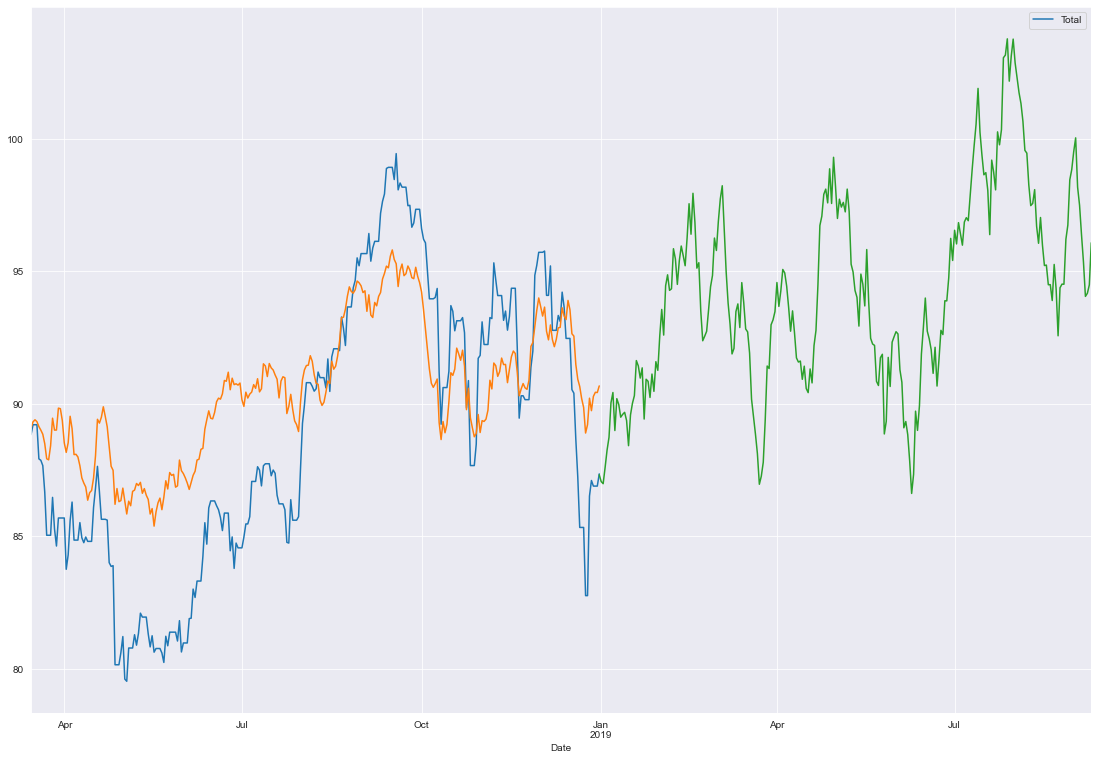

In [42]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1168] # First 80% 
test_df = tot_port_df.iloc[1168:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 460).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [43]:
forecast

2018-12-31    87.319049
2019-01-01    87.064774
2019-01-02    86.985777
2019-01-03    87.595371
2019-01-04    88.247978
                ...    
2019-09-05    95.342673
2019-09-06    94.047656
2019-09-07    94.163999
2019-09-08    94.480949
2019-09-09    96.068746
Freq: D, Length: 253, dtype: float64

In [44]:
forecast_df = pd.DataFrame(forecast)

In [45]:
forecast_df

,0
2018-12-31,87.319049
2019-01-01,87.064774
2019-01-02,86.985777
2019-01-03,87.595371
2019-01-04,88.247978
...,...
2019-09-05,95.342673
2019-09-06,94.047656
2019-09-07,94.163999
2019-09-08,94.480949


In [46]:
# add_daily_return_to_df('adj_close', forecast_df, ticker)
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [47]:
return_series

,0
2018-12-31,NaN
2019-01-01,-0.002912
2019-01-02,-0.003817
2019-01-03,0.003165
2019-01-04,0.010638
...,...
2019-09-05,0.091889
2019-09-06,0.077058
2019-09-07,0.078390
2019-09-08,0.082020


In [48]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2019-09-09  10.020376


In [31]:
#backtest

tickers2 = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

# start_date = '2017-01-03'
# end_date = '2021-09-01'

start_date = '2018-12-29'
end_date = '2019-12-31'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [32]:
panel_data2 = panel_data2['Adj Close']

In [33]:
panel_data2

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2018-12-28,49.110001,47.520000,80.783669,17.820000,121.239998,285.079987,66.475914,83.972763,53.255444,31.152008,97.487328
2018-12-31,49.700001,47.779999,81.363457,18.459999,122.449997,284.970001,66.585892,84.654251,53.862545,31.314684,97.947166
2019-01-02,50.990002,47.680000,81.317337,18.830000,119.699997,287.989990,64.854782,84.064857,52.880474,31.161036,95.530724
2019-01-03,49.150002,46.889999,78.332680,17.049999,116.500000,287.500000,65.160835,83.475433,51.987667,31.070663,96.008621
2019-01-04,51.139999,48.560001,81.034027,19.000000,121.019997,302.739990,65.356895,85.179199,53.175091,31.070663,97.442238
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,101.680000,90.910004,124.405106,46.540001,264.640015,480.859985,81.323128,118.565315,66.916771,39.676212,130.701035
2019-12-26,101.970001,91.019997,124.577156,46.630001,268.720001,485.730011,81.985329,118.565315,66.786423,40.155933,131.223709
2019-12-27,101.709999,90.820000,125.027145,46.180000,268.890015,483.690002,83.063187,119.389076,67.177475,40.174747,131.671677


In [34]:
panel_data2 * [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2018-12-28,2.4555,4.752,4.039183,1.782,12.124000,28.507999,6.647591,8.397276,5.325544,3.115201,9.748733
2018-12-31,2.4850,4.778,4.068173,1.846,12.245000,28.497000,6.658589,8.465425,5.386255,3.131468,9.794717
2019-01-02,2.5495,4.768,4.065867,1.883,11.970000,28.798999,6.485478,8.406486,5.288047,3.116104,9.553072
2019-01-03,2.4575,4.689,3.916634,1.705,11.650000,28.750000,6.516084,8.347543,5.198767,3.107066,9.600862
2019-01-04,2.5570,4.856,4.051701,1.900,12.102000,30.273999,6.535690,8.517920,5.317509,3.107066,9.744224
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,5.0840,9.091,6.220255,4.654,26.464001,48.085999,8.132313,11.856532,6.691677,3.967621,13.070103
2019-12-26,5.0985,9.102,6.228858,4.663,26.872000,48.573001,8.198533,11.856532,6.678642,4.015593,13.122371
2019-12-27,5.0855,9.082,6.251357,4.618,26.889001,48.369000,8.306319,11.938908,6.717747,4.017475,13.167168


In [35]:
return_series2 = (panel_data2.pct_change()+ 1).cumprod() - 1

In [36]:
return_series2

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,0.012014,0.005471,0.007177,0.035915,0.009980,-0.000386,0.001654,0.008116,0.011400,0.005222,0.004717
2019-01-02,0.038281,0.003367,0.006606,0.056678,-0.012702,0.010208,-0.024387,0.001097,-0.007041,0.000290,-0.020070
2019-01-03,0.000815,-0.013258,-0.030340,-0.043210,-0.039096,0.008489,-0.019783,-0.005923,-0.023806,-0.002611,-0.015168
2019-01-04,0.041336,0.021886,0.003099,0.066218,-0.001815,0.061948,-0.016833,0.014367,-0.001509,-0.002611,-0.000463
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,1.070454,0.913089,0.539978,1.611672,1.182778,0.686755,0.223347,0.411950,0.256525,0.273633,0.340698
2019-12-26,1.076359,0.915404,0.542108,1.616723,1.216430,0.703838,0.233309,0.411950,0.254077,0.289032,0.346059
2019-12-27,1.071065,0.911195,0.547678,1.591470,1.217833,0.696682,0.249523,0.421760,0.261420,0.289636,0.350654


In [37]:
weights = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

weighted_return_series = weights * return_series2
#Sum the weighted returns for SPY and TLT
return_series_x = weighted_return_series.sum(axis=1)

In [38]:
ret = return_series_x.tail(1)

In [39]:
print("Portfolio Return:", ret[-1].round(3))

Portfolio Return: 0.676


## Portfolio Analysis

In [307]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2020-01-02,0.014117,0.027931,0.011856,0.070650,0.026590,0.011029,-0.012962,-0.011930,0.026799,-0.005294,-0.003307
2020-01-03,-0.003333,-0.008772,-0.011925,-0.010183,0.003348,0.008238,0.015937,-0.006725,-0.000134,-0.009024,0.005505
2020-01-06,-0.004131,0.008957,-0.007906,-0.004321,0.019728,0.006027,0.005993,0.001387,0.018165,0.010040,-0.008424
2020-01-07,0.016296,-0.001284,0.002869,-0.002893,0.005034,0.003438,-0.017171,-0.006192,-0.037184,-0.000694,-0.016919
2020-01-08,-0.027891,0.006854,0.004715,-0.008705,0.012988,0.003225,-0.005348,0.004263,0.005910,-0.026602,0.004176


In [308]:
portfolio_weights = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI
Date,,,,,,,,,,,
2020-01-02,0.000706,0.002793,0.000593,0.007065,0.002659,0.001103,-0.001296,-0.001193,0.002680,-0.000529,-0.000331
2020-01-03,-0.000167,-0.000877,-0.000596,-0.001018,0.000335,0.000824,0.001594,-0.000673,-0.000013,-0.000902,0.000551
2020-01-06,-0.000207,0.000896,-0.000395,-0.000432,0.001973,0.000603,0.000599,0.000139,0.001816,0.001004,-0.000842
2020-01-07,0.000815,-0.000128,0.000143,-0.000289,0.000503,0.000344,-0.001717,-0.000619,-0.003718,-0.000069,-0.001692
2020-01-08,-0.001395,0.000685,0.000236,-0.000870,0.001299,0.000323,-0.000535,0.000426,0.000591,-0.002660,0.000418


In [309]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-01-02    0.014249
2020-01-03   -0.000944
2020-01-06    0.005153
2020-01-07   -0.006428
2020-01-08   -0.001483
dtype: float64

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,49.4%
Cumulative returns,49.4%
Annual volatility,33.0%
Sharpe ratio,1.38
Calmar ratio,1.75
Stability,0.83
Max drawdown,-28.3%


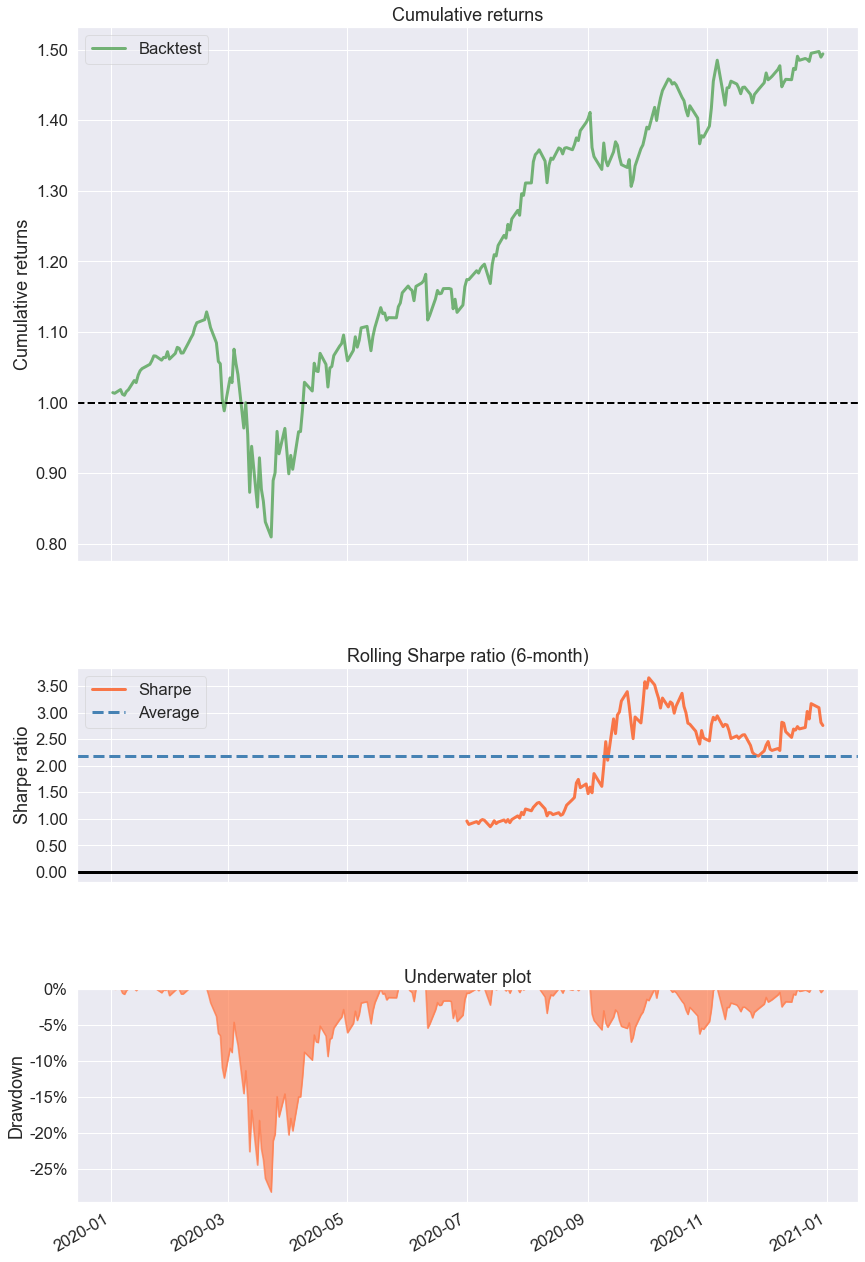

In [310]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

In [174]:
total

0      146.795540
1      148.474778
2      149.644434
3      148.652081
4      150.558223
          ...    
482    231.948567
483    231.583719
484    233.031028
485    233.089753
486    233.790910
Length: 487, dtype: float64

In [175]:
import itertools

In [176]:
test_df

,Total
Date,
2019-01-01,87.355628
2019-01-02,86.884553
2019-01-03,85.938454
2019-01-04,88.963110
2019-01-05,88.963110
...,...
2019-12-27,144.442478
2019-12-28,144.442478
2019-12-29,144.442478


In [177]:
forecast = []
for num in prediction:
    forecast.append(num)

In [178]:
actual = []

for num in test_df['Total']:
    actual.append(num)

In [179]:
forecast

[87.8563929024806,
 87.39065522605597,
 87.05993569366473,
 88.98298489589551,
 88.75224945773743,
 89.30364352021104,
 90.09492292247795,
 90.65603079309983,
 90.6049409504603,
 90.6272115838679,
 90.86340852588438,
 91.02727400231166,
 91.2226651335493,
 90.61207822739308,
 91.49670747878159,
 91.54447120441782,
 91.73328756231939,
 92.08372022853794,
 92.64843558971913,
 92.50730290604682,
 92.39547320778294,
 92.34030846893069,
 91.86205694130359,
 92.58397563065606,
 92.97302109889783,
 92.50963985784384,
 92.44630673952295,
 92.03054736508992,
 92.40474497280526,
 93.47613572566692,
 96.6733402957245,
 97.3436650638643,
 97.35545457477218,
 97.48534352929445,
 97.53914175214194,
 97.67710059858987,
 98.27882791990577,
 99.07613302184954,
 99.71026467259895,
 99.77172282260148,
 100.19603352092356,
 99.97980772019537,
 100.56226373609417,
 100.80876622488566,
 101.3494929353663,
 102.58055789146842,
 102.62404562904388,
 103.34438011899682,
 102.19185722736049,
 101.34373014483488

In [180]:
actual

[87.35562839508057,
 86.88455333709719,
 85.938454246521,
 88.96311016082765,
 88.96311016082765,
 88.96311016082765,
 89.44785842895507,
 90.06343193054198,
 89.71226043701172,
 89.4911533355713,
 89.65880737304688,
 89.65880737304688,
 89.65880737304688,
 88.44639854431152,
 89.50093059539796,
 89.4842004776001,
 89.99842338562011,
 90.56454143524171,
 90.56454143524171,
 90.56454143524171,
 90.56454143524171,
 89.6024850845337,
 90.12359924316407,
 90.17386741638185,
 91.33139781951904,
 91.33139781951904,
 91.33139781951904,
 91.22725887298584,
 90.92235603332519,
 92.16787471771242,
 97.06994667053223,
 98.55941486358643,
 98.55941486358643,
 98.55941486358643,
 98.9007890701294,
 99.60771713256835,
 100.80032138824464,
 100.84628219604494,
 101.85874595642089,
 101.85874595642089,
 101.85874595642089,
 101.01310939788819,
 101.62583179473876,
 101.69272842407226,
 102.57484111785888,
 104.10696811676027,
 104.10696811676027,
 104.10696811676027,
 104.10696811676027,
 104.18646793

In [181]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(219):

	# Calculate percentage error
	per_err = (actual[day] - forecast[day]) / actual[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.04
MAPE % : 4.01 %



In [182]:
prediction

Date
2019-01-01     87.856393
2019-01-02     87.390655
2019-01-03     87.059936
2019-01-04     88.982985
2019-01-05     88.752249
                 ...    
2019-12-27    139.254753
2019-12-28    139.501029
2019-12-29    138.921734
2019-12-30    138.670273
2019-12-31    138.537884
Freq: D, Length: 365, dtype: float64